#Student Name: ChengYang Tsai
#ECE 595 Introduction to Deep Learning
#Project 4: Adversarial Machine Learning - Student Code

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

     |████████████████████████████████| 74 kB 1.6 MB/s 
     |████████████████████████████████| 154 kB 8.4 MB/s 
     |████████████████████████████████| 42 kB 601 kB/s 


In [3]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

Using TensorFlow backend.


#Part 1: Training a target classifier

In [4]:
# Load data MNIST data and normalize to [0, 1]
(data_train, data_train_label), (data_test, data_test_label) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0
#FILL THIS IN

#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(-1, 784)
data_test = data_test.reshape(-1, 784)
print(data_train.shape)
print(data_test.shape)
#FILL THIS IN

#Convert integer labels for training and testing data into one-hot vectors 
data_train_label = keras.utils.np_utils.to_categorical(data_train_label, num_classes=10)
data_test_label = keras.utils.np_utils.to_categorical(data_test_label, num_classes=10)
#FILL THIS IN

#Create classifier architecture, compile it, and train it
def classifier():
  model = Sequential()
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))
  return model

cf = classifier()
cf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cf.fit(data_train, data_train_label, epochs=50, batch_size=256, validation_data = (data_test, data_test_label), shuffle=True)
test_loss, test_acc = cf.evaluate(data_test, data_test_label)

#FILL THIS IN



11493376/11490434 [==============================] - 2s 0us/step
(60000, 784)
(10000, 784)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.3260 - accuracy: 0.9036 - val_loss: 0.2464 - val_accuracy: 0.9448
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1222 - accuracy: 0.9653 - val_loss: 0.1219 - val_accuracy: 0.9614
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0832 - accuracy: 0.9754 - val_loss: 0.1007 - val_accuracy: 0.9696
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0613 - accuracy: 0.9821 - val_loss: 0.0891 - val_accuracy: 0.9737
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.0872 - val_accuracy: 0.9728
Epoch 6/50
60000/60000 [==================

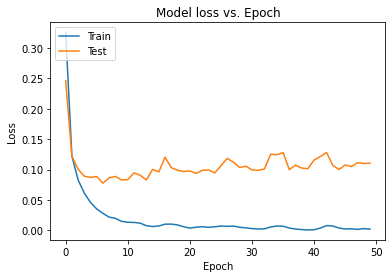

In [5]:
#Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss vs. Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#FILL THIS IN

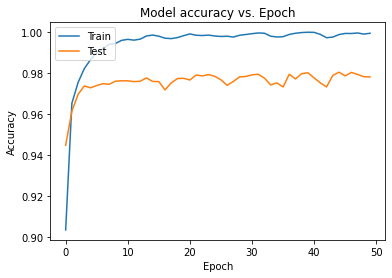

In [6]:
#Plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#FILL THIS IN

In [7]:
#Print accuracy of classifier on MNIST testing data
print("the accuracy of the trained classifier on the MNIST testing data is:", test_acc)
#FILL THIS IN

the accuracy of the trained classifier on the MNIST testing data is: 0.9781000018119812


In [8]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(cf)

#Part 2: The Fast Gradient Method (FGM)

In [9]:
#Implementing the FGSM attack
#FGM Instance on trained classifier from Part 1
fgm = FastGradientMethod(wrap, sess=sess)
#FILL THIS IN

#Attack parameters
fgm_params = {'eps':0.25,
              'clip_min':0.,
              'clip_max':1.}
#FILL THIS IN

#Generate adversarial data
fgm_attack_data = fgm.generate_np(data_test, **fgm_params)
#FILL THIS IN

#Evaluate accuracy on target classifier 
fgm_adv_scores = cf.evaluate(fgm_attack_data, data_test_label)
print('FGM Adversarial Attack Accuracy : %.2f%%' %(fgm_adv_scores[1] *100))
#FILL THIS IN




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 1s 82us/step
FGM Adversarial Attack Accuracy : 7.27%


Original ten sample images from the testing set:


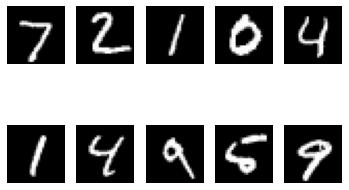

Corresponding adversarial samples after FGM attack:


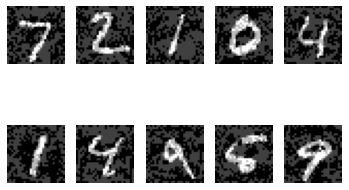

In [10]:
#Show ten original samples and their corresponding adversarial samples
r = 2
c = 5
print("Original ten sample images from the testing set:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((data_test[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

print("Corresponding adversarial samples after FGM attack:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((fgm_attack_data[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
#FILL THIS IN

In [11]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
ae = autoencoder()
ae.compile(optimizer='adam', loss='mean_squared_error')
history = ae.fit(data_train, data_train, epochs=50, batch_size=256, shuffle=True)
#FILL THIS IN

Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0371
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0121
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0085
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0068
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0057
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0051
Epoch 7/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0045
Epoch 8/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0041
Epoch 9/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0038
Epoch 10/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0035
Epoch 11/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0033
Epoch 12/50
60000/60000 [===========================

In [12]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
fgm_data_train = fgm.generate_np(data_train, **fgm_params)
#FILL THIS IN

# Obtain reconstruction errors on training set and determine a threshold 
fgm_reconstruction = ae.predict(fgm_data_train)
err = keras.losses.mean_squared_error(fgm_data_train, fgm_reconstruction)
#FILL THIS IN

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = err.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold = min(error)
print("Threshold value is:", threshold)
#FILL THIS IN

# Calculate error of adversarial testing set
fgm_test_reconstruction = ae.predict(fgm_attack_data)
err_test = keras.losses.mean_squared_error(fgm_test_reconstruction, fgm_attack_data)
error_test = err_test.eval(session=sess)
#FILL THIS IN

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
count = 0
#print(error_test.shape)
true_positive = [None]
for i in error_test:
  if i > threshold:
    true_positive.append(i)
    count = count + 1
#FILL THIS IN

# Print number of true positive samples
print("Number of true positive samples is:", count)
#FILL THIS IN  

# Determine false positives on benign testing set

data_test_orig_reconstructions = ae.predict(data_test)
test_error_orig = keras.losses.mean_squared_error(data_test_orig_reconstructions, data_test)
test_error_orig = test_error_orig.eval(session=sess)

#FILL THIS IN 


# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
count1 = 0
false_positive = [None]
for i in test_error_orig:
  if i > threshold:
    false_positive.append(i)
    count1 = count1 + 1
#FILL THIS IN 
    
# Print number of false positive samples
print("Number of false positive samples is:", count1)
#FILL THIS IN   

Threshold value is: 0.01993399
Number of true positive samples is: 10000
Number of false positive samples is: 0


#Part 3: Projected Gradient Descent

In [13]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params = {'eps':0.25,
              'eps_iter':0.01,
              'nb_iter':20,
              'clip_min':0.0,
              'clip_max':1.0}
#FILL THIS IN

#Generate adversarial data
pgd_attack_data = pgd.generate_np(data_test, **pgd_params)
#FILL THIS IN

#Evaluate accuracy of perturbed data on target classifier
pgd_adv_scores = cf.evaluate(pgd_attack_data, data_test_label)
print('PGD adversarial attack: accuracy of perturbed data on target classifier: %.2f%%' %(pgd_adv_scores[1] *100))
#FILL THIS IN


10000/10000 [==============================] - 1s 78us/step
PGD adversarial attack: accuracy of perturbed data on target classifier: 0.98%


Original ten sample images from the testing set:


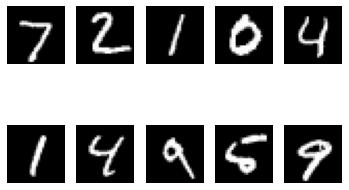

Corresponding adversarial samples after PGD attack:


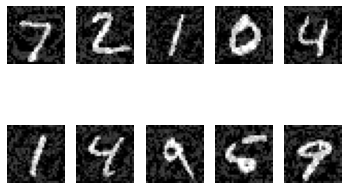

In [14]:
#Show ten original samples and their corresponding adversarial samples
r = 2
c = 5
print("Original ten sample images from the testing set:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((data_test[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

print("Corresponding adversarial samples after PGD attack:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((pgd_attack_data[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
#FILL THIS IN 

In [15]:
#Implementing the adversarial training defense
pgd_data_train = pgd.generate_np(data_train, **pgd_params)
import copy
pgd_cf = copy.deepcopy(cf)
pgd_cf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pgd_and_orig_data_train = np.concatenate((pgd_data_train,data_train),axis=0)
concat_data_train_label = np.concatenate((data_train_label,data_train_label),axis=0)
pgd_and_orig_data_test = np.concatenate((pgd_attack_data,data_test),axis=0)
concat_data_test_label = np.concatenate((data_test_label,data_test_label),axis=0)

history = pgd_cf.fit(pgd_and_orig_data_train, concat_data_train_label, validation_data=(pgd_and_orig_data_test, concat_data_test_label), epochs=50, batch_size=256, shuffle=True)
#FILL THIS INos

Train on 120000 samples, validate on 20000 samples
Epoch 1/50
120000/120000 [==============================] - 5s 42us/step - loss: 0.8724 - accuracy: 0.8799 - val_loss: 0.1588 - val_accuracy: 0.9607
Epoch 2/50
120000/120000 [==============================] - 4s 36us/step - loss: 0.0668 - accuracy: 0.9794 - val_loss: 0.1249 - val_accuracy: 0.9721
Epoch 3/50
120000/120000 [==============================] - 4s 35us/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 0.1238 - val_accuracy: 0.9751
Epoch 4/50
120000/120000 [==============================] - 4s 35us/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.1295 - val_accuracy: 0.9751
Epoch 5/50
120000/120000 [==============================] - 4s 35us/step - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.1341 - val_accuracy: 0.9760
Epoch 6/50
120000/120000 [==============================] - 4s 35us/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.1417 - val_accuracy: 0.9767
Epoch 7/50
120000/120000 [=============================

In [16]:
#Using the defense to evaluate the accuracy of the perturbed data
pgd_cf_scores = pgd_cf.evaluate(pgd_attack_data, data_test_label)
print('PGD adversarial attack: accuracy of perturbed data on re-trained network: %2f%%' %(pgd_cf_scores[1]*100))
#FILL THIS IN 

10000/10000 [==============================] - 1s 84us/step
PGD adversarial attack: accuracy of perturbed data on re-trained network: 97.700000%


#Part 4: Carlini and Wagner Attack

In [17]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
cw = CarliniWagnerL2(wrap, sess=sess)
#FILL THIS IN


#Attack parameters
cw_params = {'binary_search_steps':1,
             'y':None,
             'learning_rate':1.25,
             'batch_size':16,
             'initial_const':10,
             'clip_min':0.0,
             'clip_max':1.0}
#FILL THIS IN


#Generate adversarial data
cw_attack_data = cw.generate_np(data_test, **cw_params)
#FILL THIS IN


#Evaluate accuracy of perturbed data on target classifier
cw_adv_scores = cf.evaluate(cw_attack_data, data_test_label)
print("CW adverserial attack: accuracy of perturbed data on target classifier: %2f%%" %(cw_adv_scores[1]*100))
#FILL THIS IN


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 1s 84us/step
CW adverserial attack: accuracy of perturbed data on target classifier: 1.670000%


Original ten sample images from the testing set:


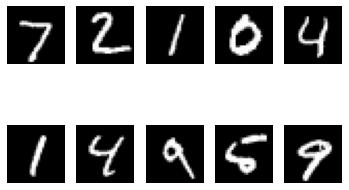

Corresponding adversarial samples after CW attack:


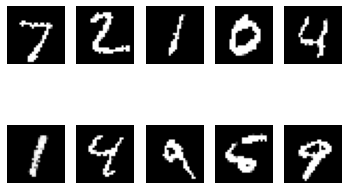

In [18]:
#Show ten original samples and their corresponding adversarial samples
r = 2
c = 5
print("Original ten sample images from the testing set:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((data_test[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

print("Corresponding adversarial samples after CW attack:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((cw_attack_data[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
#FILL THIS IN 

In [19]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
pca_cw_attack_data = pca.transform(cw_attack_data)
#FILL THIS IN 

# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=100))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    #FILL THIS IN 
    return model

#Create model graph, compile it, and train it using pca_train lables_train 
pca_model = pca_model()
pca_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
history = pca_model.fit(pca_train, data_train_label, validation_data = (pca_test, data_test_label), epochs=50, batch_size=256, shuffle=True)
#FILL THIS IN 


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.4718 - accuracy: 0.8569 - val_loss: 0.2148 - val_accuracy: 0.9473
Epoch 2/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1546 - accuracy: 0.9554 - val_loss: 0.1274 - val_accuracy: 0.9612
Epoch 3/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.1045 - accuracy: 0.9701 - val_loss: 0.1030 - val_accuracy: 0.9689
Epoch 4/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0784 - accuracy: 0.9773 - val_loss: 0.0901 - val_accuracy: 0.9720
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0610 - accuracy: 0.9822 - val_loss: 0.0818 - val_accuracy: 0.9746
Epoch 6/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0479 - accuracy: 0.9865 - val_loss: 0.0786 - val_accuracy: 0.9761
Epoch 7/50
60000/60000 [==============================] - 2s 31us/s

In [20]:
#Using the defense (and comparing to baseline accuracy)
pca_def_scores = pca_model.evaluate(pca_cw_attack_data, data_test_label)
print("CW adverserial attack: accuracy after defense through PCA Model: %2f%%" %(pca_def_scores[1]*100))
#FILL THIS IN 

10000/10000 [==============================] - 1s 84us/step
CW adverserial attack: accuracy after defense through PCA Model: 86.210001%


#Part 5: DeepFool 

In [21]:
#Implementing the DeepFool attack
#DeepFool Instance on trained classifier from Part 1
df = DeepFool(wrap, sess=sess)
#FILL THIS IN


#Attack parameters
df_params = {'nb_candidate':10,
             'max_iter':50,
             'clip_min':0.0,
             'clip_max':1.0}
#FILL THIS IN


#Generate adversarial data
df_attack_data = df.generate_np(data_test, **df_params)
#FILL THIS IN


#Evaluate accuracy of perturbed data on target classifier
df_adv_scores = cf.evaluate(df_attack_data, data_test_label)
print("DF adverserial attack: accuracy of perturbed data on target classifier: %2f%%" %(df_adv_scores[1]*100))
#FILL THIS IN

10000/10000 [==============================] - 1s 79us/step
DF adverserial attack: accuracy of perturbed data on target classifier: 1.630000%


Original ten sample images from the testing set:


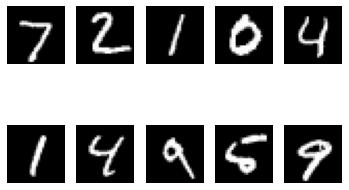

Corresponding adversarial samples after DF attack:


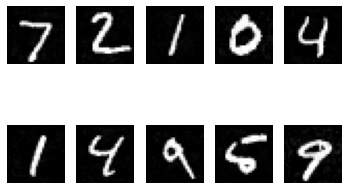

In [22]:
#Show ten original samples and their corresponding adversarial samples
r = 2
c = 5
print("Original ten sample images from the testing set:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((data_test[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

print("Corresponding adversarial samples after DF attack:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((df_attack_data[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
#FILL THIS IN

In [ ]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = df.generate_np(data_train, **df_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])
data_total_train_2 = np.concatenate([data_train, data_train])

#Create and train DAE graph
dae = autoencoder()
dae.compile(loss="mean_squared_error",optimizer="adam", metrics = ["accuracy"])
history = dae.fit(data_total_train, data_total_train_2, epochs=50, batch_size=256, shuffle=True)
#FILL THIS IN

Epoch 1/50
120000/120000 [==============================] - 5s 40us/step - loss: 0.0252 - accuracy: 0.0106
Epoch 2/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0077 - accuracy: 0.0124
Epoch 3/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0054 - accuracy: 0.0131
Epoch 4/50
120000/120000 [==============================] - 5s 38us/step - loss: 0.0043 - accuracy: 0.0136
Epoch 5/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0037 - accuracy: 0.0133
Epoch 6/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0033 - accuracy: 0.0136
Epoch 7/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0029 - accuracy: 0.0139
Epoch 8/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0027 - accuracy: 0.0137
Epoch 9/50
120000/120000 [==============================] - 5s 39us/step - loss: 0.0025 - accuracy: 0.0130
Epoch 10/50
120000/120000 [==========

In [ ]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
df_attack_data_recons = dae.predict(df_attack_data)
#FILL THIS IN

#Evaluate accuracy of DeepFool samples after denoising 
df_scores = cf.evaluate(df_attack_data_recons, data_test_label)
print("DeepFool Accuracy after defence through denoising: %2f%%" %(df_scores[1]*100))
#FILL THIS IN

10000/10000 [==============================] - 1s 86us/step
DeepFool Accuracy after defence through denoising: 97.479999%


DeepFool adversarial samples after defence through denoising:


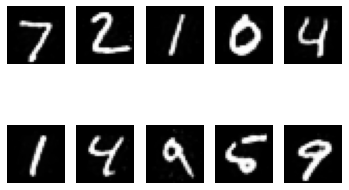

In [ ]:
#Show ten samples of adversarial samples after denoising
r = 2
c = 5
print("DeepFool adversarial samples after defence through denoising:")
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((df_attack_data_recons[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
#FILL THIS IN